In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
test_data_path=r"C:\Users\LHW\qwer\test.csv"
train_data_path=r"C:\Users\LHW\qwer\train.csv"

In [3]:
test=pd.read_csv(test_data_path)
train=pd.read_csv(train_data_path)
train.head()



,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [5]:
object_columns = train.select_dtypes(include='object').columns.difference(['education']).tolist()
object_columns

['department', 'gender', 'recruitment_channel', 'region']

In [6]:

import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# 1. 스케일링 대상 열 지정
# Optimized Transformer for combined processing
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer_rating = IterativeImputer(max_iter=10, random_state=42)
        self.imputer_education = SimpleImputer(strategy="most_frequent")
        self.scaler = StandardScaler()
        self.education_map = {'Below Secondary': 0, "Bachelor's": 1, "Master's & above": 2}
    # if not is_test:
        
    def fit(self, X, y=None):
        # Fit imputers
        self.imputer_rating.fit(X[['previous_year_rating']])
        self.imputer_education.fit(X[['education']])
        # self.scaler.fit(X[['age','avg_training_score','no_of_trainings', 'previous_year_rating', 'length_of_service']])
        return self

    def transform(self, X):
        # Handle missing values
        X[['previous_year_rating']] = self.imputer_rating.transform(X[['previous_year_rating']])
        X[['education']] = self.imputer_education.transform(X[['education']])
        
        # Ordinal encoding for 'education'
        X['education'] = X['education'].map(self.education_map)
        
        # Rename columns
        X['region'] = X['region'].str.replace('region_', '').astype(int)
        X.rename(columns={
            "employee_id": "id",
            "KPIs_met >80%": "KPIs_over_0.8",
            "awards_won?": "awards_won"
        }, inplace=True)
        
        for column in X.columns:
            if column in object_columns:
                dummies = pd.get_dummies(X[column], drop_first=True, prefix=f"{column}")
                dummies = dummies.astype(int)
                X = pd.concat([X, dummies], axis=1)
                X.drop(columns=column, inplace=True)
        # X[['age','avg_training_score','no_of_trainings', 'previous_year_rating', 'length_of_service']] = self.scaler.transform(X[['age','avg_training_score','no_of_trainings', 'previous_year_rating', 'length_of_service']])
        return X

# Create optimized pipeline
def create_pipeline():
    pipeline = Pipeline([
        ('preprocessor', Preprocessor())
    ])
    return pipeline

In [7]:
train.shape

(54808, 14)

In [8]:
train["is_promoted"].value_counts()

is_promoted
0    50140
1     4668
Name: count, dtype: int64

In [9]:
pipeline = create_pipeline()
train = pipeline.fit_transform(train)
test = pipeline.transform(test)

In [10]:
train.shape ,test.shape

((54808, 54), (23490, 53))

In [11]:
train.head()

,id,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_over_0.8,awards_won,avg_training_score,is_promoted,...,region_28,region_29,region_30,region_31,region_32,region_33,region_34,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
0,65438,2,1,35,5.0,8,1,0,49,0,...,0,0,0,0,0,0,0,0,0,1
1,65141,1,1,30,5.0,4,0,0,60,0,...,0,0,0,0,0,0,0,1,0,0
2,7513,1,1,34,3.0,7,0,0,50,0,...,0,0,0,0,0,0,0,1,0,1
3,2542,1,2,39,1.0,10,0,0,50,0,...,0,0,0,0,0,0,0,1,0,0
4,48945,1,1,45,3.0,2,0,0,73,0,...,0,0,0,0,0,0,0,1,0,0


# 오토인코더

In [48]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Input, Dense

In [49]:
train_X , train_y = train.drop(['is_promoted','id'],axis=1), train['is_promoted']

# X,y분리

In [43]:
train_X , train_y = train.drop(['is_promoted','id'],axis=1), train['is_promoted']

In [44]:
train_X.shape , train_y.shape

((54808, 52), (54808,))

In [13]:

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
logit = LogisticRegression
rf = RandomForestClassifier
xgb = XGBClassifier
lgb = LGBMClassifier
cat = CatBoostClassifier
lda= LinearDiscriminantAnalysis
qda=QuadraticDiscriminantAnalysis

In [14]:
models = {"lda":lda,"qda":qda,"logit":logit,"xgb":xgb,"lgbm":lgb,"cat":cat}

## RFECV

In [50]:
models = {"xgb":xgb,"lgbm":lgb,"cat":cat}

In [127]:
from sklearn.feature_selection import RFE, RFECV

rfe = {}
min_features_to_select = 10 # at least minimum features
step = 3 # the model eliminate three feature at one time
for idx,model in models.items():
      selector = RFECV(model(), step=step, cv=5, min_features_to_select=min_features_to_select,scoring="f1_weighted",verbose=100,n_jobs=-1)
      selector = selector.fit(train_X,train_y)
      rfe[idx] = selector.get_feature_names_out()

Fitting estimator with 52 features.
Fitting estimator with 49 features.
Fitting estimator with 46 features.
Fitting estimator with 43 features.
Fitting estimator with 40 features.
Fitting estimator with 37 features.
Fitting estimator with 34 features.
Fitting estimator with 31 features.
Fitting estimator with 28 features.
Fitting estimator with 25 features.
Fitting estimator with 22 features.
Fitting estimator with 19 features.
Fitting estimator with 16 features.
Fitting estimator with 52 features.
[LightGBM] [Info] Number of positive: 4668, number of negative: 50140
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 54808, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085170 -> initscore=-2.3

In [128]:
rfe

{'xgb': array(['previous_year_rating', 'KPIs_over_0.8', 'awards_won',
        'avg_training_score', 'department_Finance', 'department_HR',
        'department_Legal', 'department_Operations',
        'department_Procurement', 'department_R&D',
        'department_Sales & Marketing', 'department_Technology',
        'region_4'], dtype=object),
 'lgbm': array(['education', 'no_of_trainings', 'age', 'previous_year_rating',
        'length_of_service', 'KPIs_over_0.8', 'awards_won',
        'avg_training_score', 'department_Finance', 'department_HR',
        'department_Legal', 'department_Operations',
        'department_Procurement', 'department_R&D',
        'department_Sales & Marketing', 'department_Technology',
        'region_2', 'region_4', 'region_7', 'region_17', 'region_22',
        'region_23', 'region_25', 'region_26', 'region_28', 'gender_m',
        'recruitment_channel_referred', 'recruitment_channel_sourcing'],
       dtype=object),
 'cat': array(['education', 'no_of_train

In [129]:
import os
import joblib
# adjust path
PATH ='C:/Users/LHW/qwer'
features_dir = os.path.join(PATH, 'features')
# if feature folder not exists then create
if not os.path.exists(features_dir):
    os.makedirs(features_dir)
if rfe:
    for model_name in rfe:
        file_name = os.path.join(features_dir, f'{model_name}.pkl')
        joblib.dump(rfe[model_name], file_name)

In [130]:
import glob
import joblib

pkl_files = glob.glob(f"{features_dir}/*.pkl")

for file_path in pkl_files:
  loaded_object = joblib.load(file_path)
  print(loaded_object)

['education' 'no_of_trainings' 'age' 'previous_year_rating'
 'length_of_service' 'KPIs_over_0.8' 'awards_won' 'avg_training_score'
 'department_Finance' 'department_HR' 'department_Legal'
 'department_Operations' 'department_Procurement'
 'department_Sales & Marketing' 'department_Technology' 'region_2'
 'region_4' 'region_7' 'region_9' 'region_15' 'region_17' 'region_22'
 'region_23' 'region_27' 'region_28' 'gender_m'
 'recruitment_channel_referred' 'recruitment_channel_sourcing']
['education' 'no_of_trainings' 'age' 'previous_year_rating'
 'length_of_service' 'KPIs_over_0.8' 'awards_won' 'avg_training_score'
 'department_Finance' 'department_HR' 'department_Legal'
 'department_Operations' 'department_Procurement' 'department_R&D'
 'department_Sales & Marketing' 'department_Technology' 'region_2'
 'region_4' 'region_7' 'region_17' 'region_22' 'region_23' 'region_25'
 'region_26' 'region_28' 'gender_m' 'recruitment_channel_referred'
 'recruitment_channel_sourcing']
['previous_year_rati

## 하이퍼 파라미터 튜닝

In [15]:
rfe={}

In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

class OptunaOptimizer:
    def __init__(self, models, train_X, train_y, metric, rfe=None):
        self.models = models
        self.train_X = train_X
        self.train_y = train_y
        self.metric = metric
        self.rfe = rfe if rfe else {model_name: train_X.columns.tolist() for model_name in models}
        self.studies = {}
        self.best_models = {}
        self.scaler = StandardScaler()

    def objective(self, trial, model_class, model_name):
        selected_features = self.rfe[model_name]
        train_X_filtered = self.train_X[selected_features]

        if model_class == LogisticRegression:
            param = {
                'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
                'C': trial.suggest_float('C', 1e-4, 1e4, log=True),
                'solver': trial.suggest_categorical('solver', ['saga']),
                'l1_ratio': trial.suggest_float('l1_ratio', 0, 1, log=False)
            }
        elif model_class == XGBClassifier:
            param = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
            }
        elif model_class == LGBMClassifier:
            param = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'num_leaves': trial.suggest_int('num_leaves', 20, 150),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
            }
        elif model_class == RandomForestClassifier:
            param = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
            }
        elif model_class == LinearDiscriminantAnalysis:
            solver = trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
            param = {'solver': solver}
            if solver in ['lsqr', 'eigen']:
                param['shrinkage'] = trial.suggest_categorical('shrinkage', ['auto', None])
                if param['shrinkage'] is None:
                    param['shrinkage'] = trial.suggest_float('shrinkage_float', 0.0, 1.0)
        elif model_class == QuadraticDiscriminantAnalysis:
            param = {
                'reg_param': trial.suggest_float('reg_param', 0.0, 1.0)
            }
        elif model_class == SVC:
            kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
            param = {
                'C': trial.suggest_float('C', 1e-4, 1e4, log=True),
                'kernel': kernel,
                'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
            }
            if kernel == 'poly':
                param['degree'] = trial.suggest_int('degree', 2, 5)
                param['coef0'] = trial.suggest_float('coef0', 0.0, 1.0)
            if kernel == 'sigmoid':
                param['coef0'] = trial.suggest_float('coef0', 0.0, 1.0)
        elif model_class == CatBoostClassifier:
            param = {
                'iterations': trial.suggest_int('iterations', 100, 500),
                'depth': trial.suggest_int('depth', 4, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-1, 1e2, log=True),
                'border_count': trial.suggest_int('border_count', 1, 255),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
                'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
                'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
                'od_wait': trial.suggest_int('od_wait', 10, 50)
            }

        train_split_X, val_X, train_split_y, val_y = train_test_split(train_X_filtered, self.train_y, test_size=0.2, random_state=42, stratify=self.train_y)
        train_split_X = self.scaler.fit_transform(train_split_X)
        val_X = self.scaler.transform(val_X)
        model = model_class(**param)
        model.fit(train_split_X, train_split_y)

        pred_y = model.predict(val_X)
        if self.metric == 'f1_score':
            score = f1_score(val_y, pred_y, average='macro')
        elif self.metric == 'accuracy_score':
            score = accuracy_score(val_y, pred_y)
        elif self.metric == 'roc_auc_score':
            score = roc_auc_score(val_y, model.predict_proba(val_X)[:, 1])
        return score

    def optimize(self, n_trials=100):
        for model_name, model_class in self.models.items():
            print(f"Starting hyperparameter tuning for {model_name}")
            study = optuna.create_study(direction='maximize')
            study.optimize(lambda trial: self.objective(trial, model_class, model_name), n_trials=n_trials)
            self.studies[model_name] = study
            print(f"Best parameters for {model_name}: {study.best_params}")
            print(f"Best {self.metric} for {model_name}: {study.best_value}")
            print(study)
            
    def train_best_models(self):
        for model_name, model_class in self.models.items():
            selected_features = self.rfe[model_name]
            train_X_filtered = self.train_X[selected_features]
            best_params = self.studies[model_name].best_params
            best_model = model_class(**best_params)
            
            # 데이터 스케일링
            train_split_X, val_X, train_split_y, val_y = train_test_split(train_X_filtered, self.train_y, test_size=0.2, random_state=42, stratify=self.train_y)
            train_split_X = self.scaler.fit_transform(train_split_X)
            val_X = self.scaler.transform(val_X)
            
            best_model.fit(train_split_X, train_split_y)
            self.best_models[model_name] = best_model

            pred_y = best_model.predict(val_X)
            f1 = f1_score(val_y, pred_y, average='binary')
            print(f"F1 score with best parameters for {model_name}: {f1}")


# Optimizer 인스턴스 생성 및 최적화 수행
optimizer = OptunaOptimizer(models, train_X, train_y, 'f1_score', rfe)
optimizer.optimize(n_trials=30)
optimizer.train_best_models()

In [17]:
optimizer.models

{'logistic_regression': sklearn.linear_model._logistic.LogisticRegression,
 'xgboost': xgboost.sklearn.XGBClassifier,
 'lightgbm': lightgbm.sklearn.LGBMClassifier,
 'random_forest': sklearn.ensemble._forest.RandomForestClassifier,
 'lda': sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
 'qda': sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis,
 'catboost': catboost.core.CatBoostClassifier}

### 모델 저장

In [18]:
import joblib
import os
# 저장 경로 설정
PATH = 'C:/Users/LHW/qwer'
models_dir = os.path.join(PATH, 'models')

# 디렉토리가 없으면 생성
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# 최적의 모델 저장
for model_name, best_model in optimizer.best_models.items():
    file_name = os.path.join(models_dir, f'{model_name}.pkl')  # 최적 모델 저장 파일명
    joblib.dump(best_model, file_name)
    print(f"Model '{model_name}' saved to {file_name}")


Model 'logistic_regression' saved to C:/Users/LHW/qwer\models\logistic_regression.pkl
Model 'xgboost' saved to C:/Users/LHW/qwer\models\xgboost.pkl
Model 'lightgbm' saved to C:/Users/LHW/qwer\models\lightgbm.pkl
Model 'random_forest' saved to C:/Users/LHW/qwer\models\random_forest.pkl
Model 'lda' saved to C:/Users/LHW/qwer\models\lda.pkl
Model 'qda' saved to C:/Users/LHW/qwer\models\qda.pkl
Model 'catboost' saved to C:/Users/LHW/qwer\models\catboost.pkl


In [13]:
import glob
import joblib
folder_path = 'models'
pkl_files = glob.glob(f"{folder_path}/*.pkl")

models = {}
for file_path in pkl_files:
    model_name = file_path.split("\\")[-1].split(".")[0]  # 모델 이름 추출
    loaded_model = joblib.load(file_path)  # 모델 로드
    models[model_name] = loaded_model  # 모델 저장

In [14]:
models

{'cat': <catboost.core.CatBoostClassifier at 0x165775ee2d0>,
 'catboost': <catboost.core.CatBoostClassifier at 0x16577608bd0>,
 'lda': LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen'),
 'lgbm': LGBMClassifier(colsample_bytree=0.9938562211970143,
                learning_rate=0.28741559979405745, max_depth=9,
                min_child_samples=51, n_estimators=446, num_leaves=95,
                reg_alpha=0.46373702875820844, reg_lambda=0.8611830917982986,
                subsample=0.7109847547194308),
 'lightgbm': LGBMClassifier(colsample_bytree=0.6497667497932044,
                learning_rate=0.12669681574071334, max_depth=8,
                min_child_samples=83, n_estimators=354, num_leaves=147,
                reg_alpha=0.7643089115176547, reg_lambda=0.3648115907719341,
                subsample=0.7926608066012206),
 'logistic_regression': LogisticRegression(C=9324.89244447503, l1_ratio=0.9076276067220655,
                    penalty='l1', solver='saga'),
 'logit': Logis

In [26]:
test.drop('id',axis=1,inplace=True)

In [27]:
train_X.head()

,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_over_0.8,awards_won,avg_training_score,department_Finance,department_HR,...,region_28,region_29,region_30,region_31,region_32,region_33,region_34,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
19004,1,1,27,3.0,4,0,0,52,0,0,...,0,0,0,0,0,0,0,1,0,0
54186,1,2,38,4.0,10,1,0,79,0,0,...,0,0,0,0,0,0,0,0,0,0
37539,1,1,26,1.0,3,0,0,57,0,0,...,0,0,0,0,0,0,0,1,0,1
51713,1,1,27,2.0,4,0,0,49,0,0,...,0,0,0,0,0,0,0,0,0,1
2051,1,1,28,3.0,2,0,0,66,0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
train_X,val_X,train_y,val_y = train_test_split(train_X,train_y,test_size=0.3,random_state=42,stratify=train_y)
train_X_s = scaler.fit_transform(train_X)
val_X_s = scaler.transform(val_X)
test_X_s = scaler.transform(test)


In [18]:
train_X_s.shape, val_X_s.shape, test_X_s.shape

((38365, 52), (16443, 52), (23490, 52))

In [30]:
train_y.shape, val_y.shape

((26855,), (11510,))

In [20]:
from sklearn.ensemble import StackingClassifier  ,RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
# Base_model Level 0
xgb = XGBClassifier()
knn = KNeighborsClassifier(n_neighbors=2, weights="distance")
base_models = [
    ('lgbm',models['lgbm']),
    ('cat',models['cat']),
    ('lda', models['lda']),
    ('xgb',xgb)]


# KerasClassifier 래퍼를 사용하여 신경망 모델을 메타 러너로 사용
meta_model = models['lda']
# Stacking Classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model,n_jobs=-1, cv=5)


stacking_model.fit(train_X_s,train_y)


y_pred = stacking_model.predict(val_X_s)
print(f'recall_score : {recall_score(train_y,y_pred)}')

ValueError: Found input variables with inconsistent numbers of samples: [38365, 16443]

In [28]:
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [29]:
sum(y_pred)

979

In [30]:
sub = pd.read_csv('submission.csv')
sub

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0
...,...,...
23485,53478,0
23486,25600,0
23487,45409,0
23488,1186,0


In [31]:
sub['is_promoted'] = y_pred
sum(sub['is_promoted'])

979

In [33]:
x_pred = models['xgb'].predict(test_X_s)
sum(x_pred)

400

In [32]:
sub.to_csv('C:/Users/LHW/Downloads/try.csv',index=False)

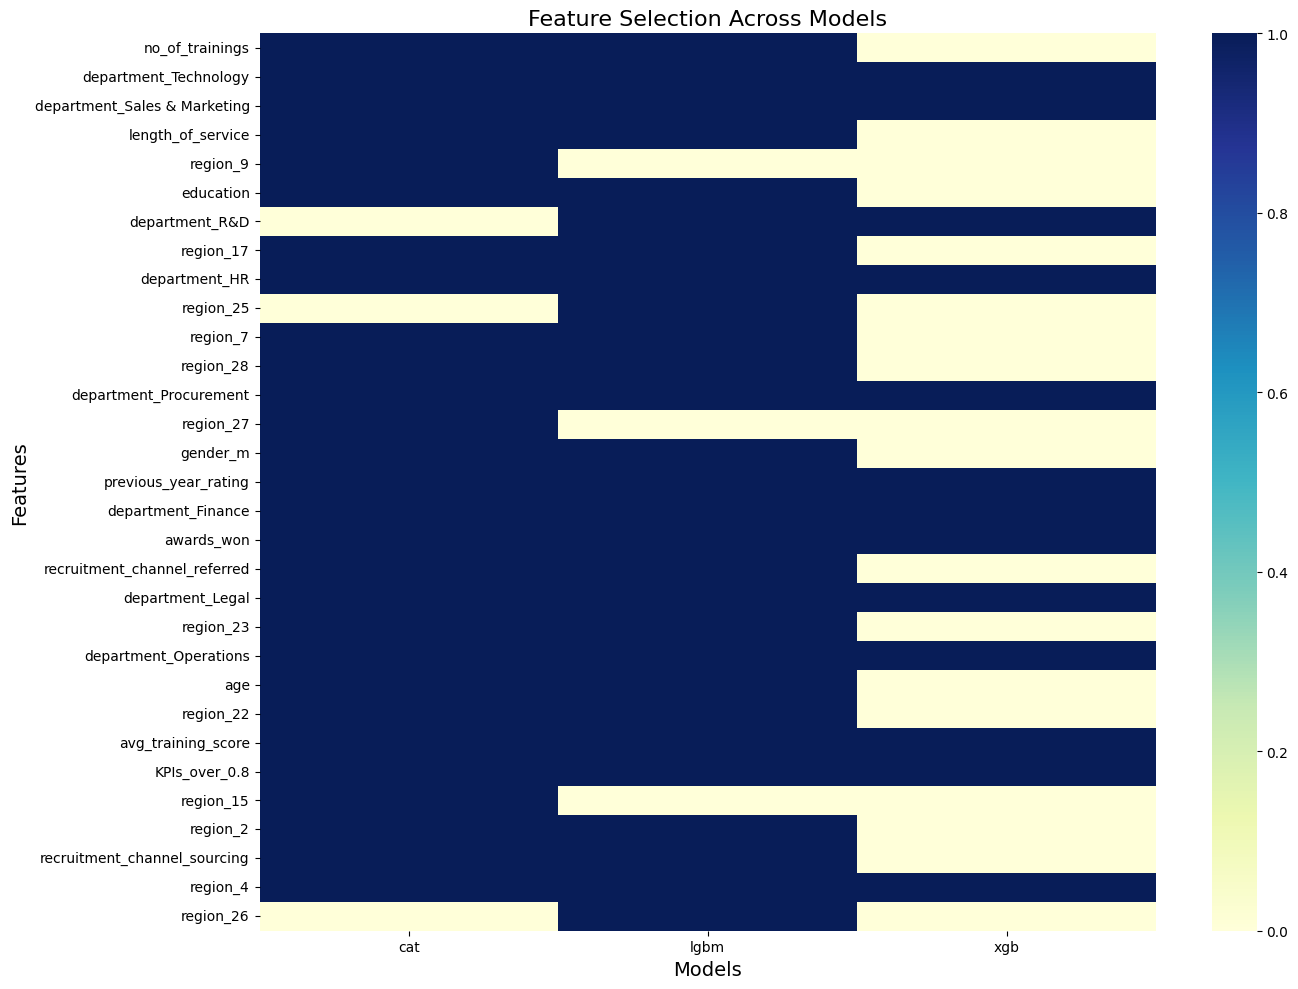

In [143]:
import glob
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 모델에서 선택된 피처를 자동으로 로드하는 함수
def load_features_from_files(folder_path):
    # 특정 폴더의 모든 .pkl 파일 로드
    pkl_files = glob.glob(f"{folder_path}/*.pkl")
    feature_data = {}

    for file_path in pkl_files:
        model_name = file_path.split("features\\")[-1].split(".")[0]  # 파일명에서 모델 이름 추출
        loaded_object = joblib.load(file_path)  # .pkl 파일 로드
        feature_data[model_name] = list(loaded_object)  # 피처 리스트 저장

    return feature_data

# Step 1: 모델의 피처 로드
folder_path = "features"  # 피처 저장 폴더 경로
data = load_features_from_files(folder_path)

# Step 2: 이진 매트릭스 생성
all_features = list(set(sum(data.values(), [])))  # 모든 피처 추출 (중복 제거)
df = pd.DataFrame(
    {model: [1 if feature in features else 0 for feature in all_features] for model, features in data.items()},
    index=all_features
)

# Step 3: 히트맵 시각화
plt.figure(figsize=(14, 10))
sns.heatmap(df, annot=False, cmap="YlGnBu", cbar=True)
plt.title("Feature Selection Across Models", fontsize=16)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.tight_layout()
plt.show()
